In [18]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from scipy.ndimage import shift

from pathlib import Path
import tarfile
import urllib.request

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [7]:
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target
mnist.target_names

['class']

In [8]:
def plot_image(image_data):
    image = image_data.reshape(28, 28)
    plt.plot(image, cmap='binary')
    plt.axis('off')

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

In [20]:
param_grid = [{
    'weights': ['uniform', 'distance'],
    'n_neighbors': [3,4,5,6]
}]

knn_grid_clf = GridSearchCV(knn_clf, param_grid, cv = 3)
knn_grid_clf.fit(X_train[:5000], y_train[:5000])

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [23]:
knn_grid_clf.best_estimator_
knn_grid_clf.best_score_
knn_grid_clf.best_estimator_.fit(X_train, y_train)
tuned_accuracy = knn_grid_clf.score(X_test, y_test)
tuned_accuracy

0.9714

In [52]:
# Data Augmentation

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted_image = shift(image, [dy,dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

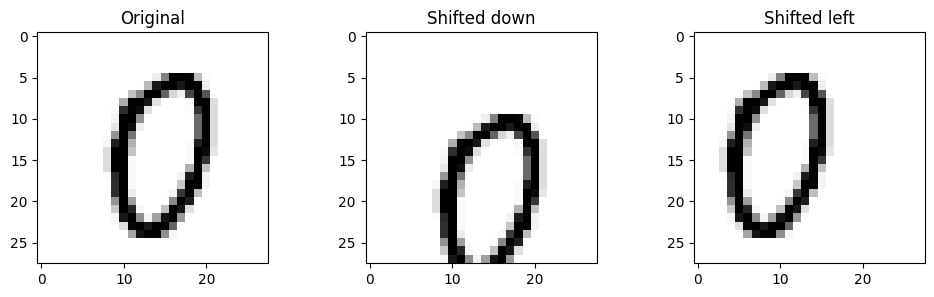

In [57]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")

In [58]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)
        

In [59]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [60]:
knn_clf = KNeighborsClassifier(**knn_grid_clf.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [61]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


In [7]:
def load_dataset():
    tarpath = Path("datasets/titanic.tgz")
    if not tarpath.is_file():
        Path('datasets').mkdir(parents=True, exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/titanic.tgz'
        urllib.request.urlretrieve(url, tarpath)
        with tarfile.open(tarpath) as titanic_tarball:
            titanic_tarball.extractall(path='datasets')
    return [pd.read_csv(Path('datasets/titanic')/filename) for filename in ('train.csv', 'test.csv')]

In [13]:
train_data, test_data = load_dataset()

In [15]:
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')